<a href="https://colab.research.google.com/github/muxitox/nanoGPT/blob/master/explore_gpt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download repo

In [1]:
! git clone https://github.com/muxitox/nanoGPT.git

Cloning into 'nanoGPT'...
remote: Enumerating objects: 1055, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 1055 (delta 69), reused 64 (delta 53), pack-reused 966 (from 4)
Receiving objects: 100% (1055/1055), 1.08 MiB | 18.05 MiB/s, done.
Resolving deltas: 100% (494/494), done.


In [2]:
%cd nanoGPT

/content/nanoGPT


# Install dependencies

In [3]:
! pip install torch==2.2.2 torchvision torchaudio numpy transformers datasets tiktoken wandb tqdm

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 

In [4]:
! pip install fsspec==2024.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.2.0 requires fsspec[http]<=2024.9.0,>=2023.1.0, but you have fsspec 2024.10.0 which is incompatible.


# Import packages

In [5]:
"""
Import required libraries
"""
import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken
from model_tests import GPTConfig, GPT
import matplotlib.pyplot as plt

# Config

In [6]:
# -----------------------------------------------------------------------------
init_from = 'gpt2' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = 'out-shakespeare-gpu' # ignored if init_from is not 'resume'


seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float32' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster
# exec(open('configurator.py').read()) # overrides from command line or config file, not needed in this execution

In [7]:
# -----------------------------------------------------------------------------
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

In [8]:
# model
if init_from == 'resume':
    # init from a model saved in a specific directory
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf, compute_statistics=True)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
elif init_from.startswith('gpt2'):
    # init from a given GPT-2 model
    model = GPT.from_pretrained(init_from, dict(dropout=0.0))

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### Load model

In [9]:
model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)

In [10]:
# look for the meta pickle in case it is available in the dataset folder
load_meta = False
if init_from == 'resume' and 'config' in checkpoint and 'dataset' in checkpoint['config']: # older checkpoints might not have these...
    meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
    load_meta = os.path.exists(meta_path)
if load_meta:
    print(f"Loading meta from {meta_path}...")
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
    stoi, itos = meta['stoi'], meta['itos']
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
else:
    # ok let's assume gpt-2 encodings by default
    print("No meta.pkl found, assuming GPT-2 encodings...")
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)

No meta.pkl found, assuming GPT-2 encodings...


# Explore model

In [14]:
def explore_model(start_text, temperature, top_k):

    # encode the beginning of the prompt
    if start_text.startswith('FILE:'):
        with open(start_text[5:], 'r', encoding='utf-8') as f:
            start = f.read()

    start_ids = encode(start_text)
    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

    # run generation
    x_tensor = torch.zeros((num_samples, max_new_tokens, model.config.n_embd), device=device)
    q_tensor = torch.zeros((num_samples, max_new_tokens, model.config.n_head, model.config.n_embd // model.config.n_head), device=device)

    with torch.no_grad():
        with ctx:
            for k in range(num_samples):
                y, x_array, q_matrix = model.generate_comp_stats(x, max_new_tokens, temperature=temperature, top_k=top_k)
                x_tensor[k] = x_array
                q_tensor[k] = q_matrix


                if k % 500 == 0:
                    print("Computing sample ", k)

                plot_samples = False
                if plot_samples:
                    print("Sample len", len(y[0].tolist()))
                    print('---------------')
                    print(decode(y[0].tolist()))
                    print('---------------')


        # Re-compute mean projection
        layer_i = 0
        # Get separate weights
        Wq, Wk, Wv = model.transformer.h[layer_i].attn.c_attn.weight.split(model.config.n_embd)

        # Divide weight in n_head heads
        Wq_h = Wq.view(model.config.n_head, model.config.n_embd // model.config.n_head, model.config.n_embd)
        Wk_h = Wk.view(model.config.n_head, model.config.n_embd // model.config.n_head, model.config.n_embd)
        Wv_h = Wv.view(model.config.n_head, model.config.n_embd // model.config.n_head, model.config.n_embd)


        # To get the projection for all the heads with some x:
        mq_h = torch.matmul( Wq_h, x_tensor[0, -1])


        fig, ax = plt.subplots(3, 3)
        ax_ravel = ax.ravel()
        print("Plot q")
        for i in range(0, 3):
            # Examine feat feat_a from head h_i for different samples
            h_i = torch.randint(model.config.n_head, (1,))[0]
            feat_a = torch.randint(model.config.n_embd // model.config.n_head, (1,))[0]
            print(h_i, feat_a)

            mq_h_i_a = torch.matmul(Wq_h[h_i, feat_a], x_tensor[:, -1].T)
            print("Unique", len(torch.unique(mq_h_i_a)))
            ax_ravel[i].hist(mq_h_i_a.cpu(), bins=50)
            ax_ravel[i].axvline(mq_h_i_a.mean().cpu(), color='k', linestyle='dashed', alpha=0.7)
            ax_ravel[i].set_title(f"m^q_{{{h_i},{feat_a}}}")


        print("Plot k")
        for i in range(3, 6):
            # Examine feat feat_a from head h_i for different samples
            h_i = torch.randint(model.config.n_head, (1,))[0]
            feat_a = torch.randint(model.config.n_embd // model.config.n_head, (1,))[0]
            print(h_i, feat_a)

            mk_h_i_a = torch.matmul(Wk_h[h_i, feat_a], x_tensor[:, -1].T)
            print("Unique", len(torch.unique(mk_h_i_a)))
            ax_ravel[i].hist(mk_h_i_a.cpu(), bins=50)
            ax_ravel[i].axvline(mk_h_i_a.mean().cpu(), color='k', linestyle='dashed', alpha=0.7)
            ax_ravel[i].set_title(f"m^k_{{{h_i},{feat_a}}}")


        print("Plot v")
        for i in range(6 , 9):
            # Examine feat feat_a from head h_i for different samples
            h_i = torch.randint(model.config.n_head, (1,))[0]
            feat_a = torch.randint(model.config.n_embd // model.config.n_head, (1,))[0]
            print(h_i, feat_a)

            mv_h_i_a = torch.matmul(Wv_h[h_i, feat_a], x_tensor[:, -1].T)
            print("Unique", len(torch.unique(mv_h_i_a)))
            ax_ravel[i].hist(mv_h_i_a.cpu(), bins=50)
            ax_ravel[i].axvline(mv_h_i_a.mean().cpu(), color='k', linestyle='dashed', alpha=0.7)
            ax_ravel[i].set_title(f"m^v_{{{h_i},{feat_a}}}")


        fig.show()


In [22]:
num_samples = 20000 # number of samples to draw
max_new_tokens = 2 # number of tokens generated in each sample, we generate 2 tokens since in the second pass we are collecting the token representation of the 1st selected token

### "\n" start, check different temperatures

In [23]:
# Select context:
start = "\n" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
top_k = 20000

T = 0.8

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(7) tensor(57)
Unique 1510
tensor(6) tensor(33)
Uni

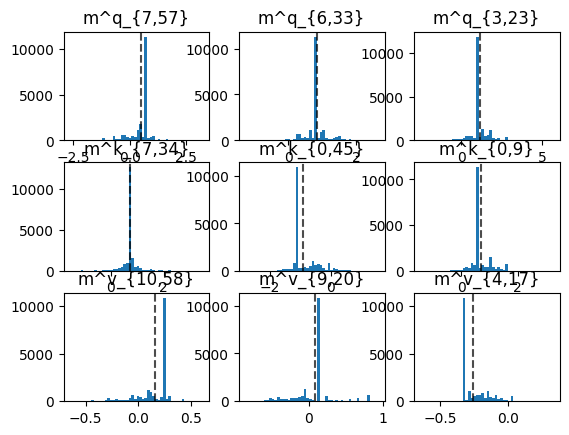

In [24]:
# Select context:
temperature = 0.8

explore_model(start, temperature, top_k)

T = 1

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(10) tensor(51)
Unique 3694
tensor(1) tensor(53)
Un

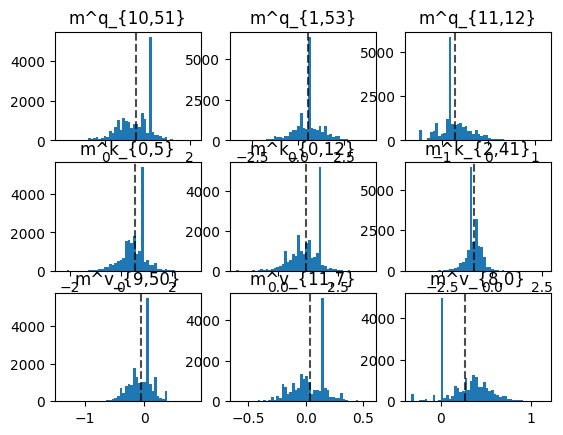

In [25]:

temperature = 1
explore_model(start, temperature, top_k)

T = 3

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(11) tensor(54)
Unique 11354
tensor(5) tensor(62)
U

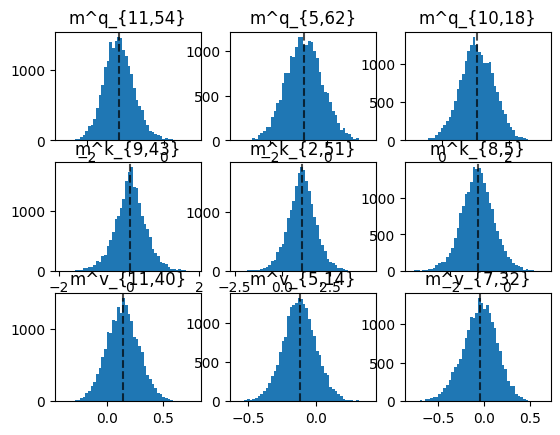

In [26]:
temperature = 3

explore_model(start, temperature, top_k)

### Short sentence 1 (from The Lion King article in Wikipedia)

In [27]:
start = "\nThe Lion King was conceived during conversations among various Disney executives, to whom several writers submitted early treatments. Original director George Scribner had envisioned"
top_k = 20000

T = 0.8

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(2) tensor(41)
Unique 458
tensor(10) tensor(51)
Uni

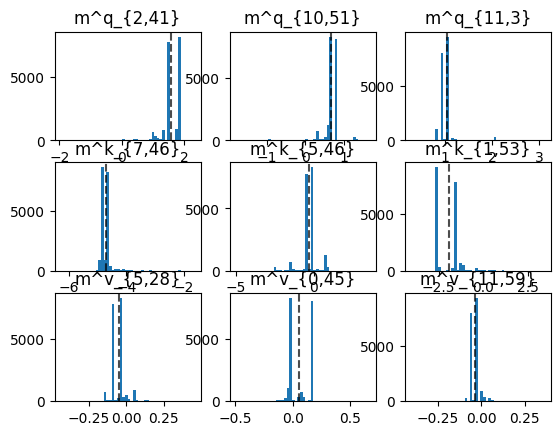

In [28]:
temperature = 0.8
explore_model(start, temperature, top_k)

T = 1

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(4) tensor(26)
Unique 1721
tensor(5) tensor(6)
Uniq

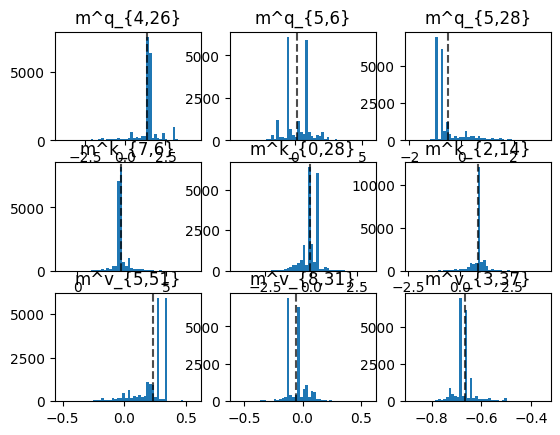

In [29]:
temperature = 1
explore_model(start, temperature, top_k)

T = 3

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(1) tensor(39)
Unique 11244
tensor(8) tensor(7)
Uni

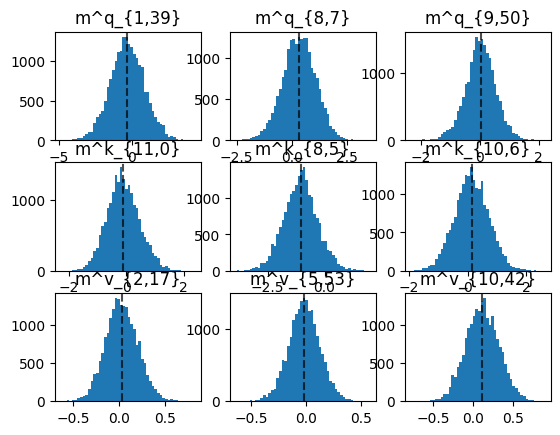

In [30]:
temperature = 3
explore_model(start, temperature, top_k)

### Short sentence 1 (cropped before)

In [31]:
start = "\nThe Lion King was conceived during"
top_k = 20000

T = 0.8

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(7) tensor(46)
Unique 594
tensor(4) tensor(35)
Uniq

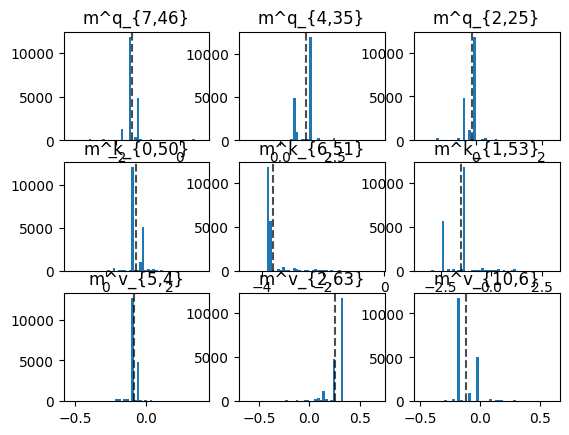

In [32]:
# Select context:
temperature = 0.8
explore_model(start, temperature, top_k)

T = 1

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(5) tensor(3)
Unique 2103
tensor(5) tensor(57)
Uniq

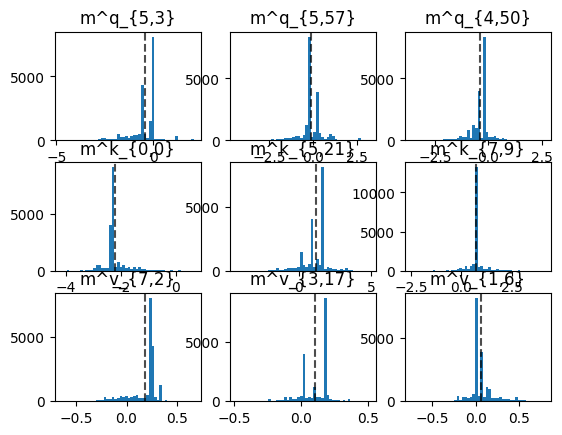

In [33]:
# Select context:
temperature = 1
explore_model(start, temperature, top_k)

T = 3

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(6) tensor(52)
Unique 11243
tensor(10) tensor(27)
U

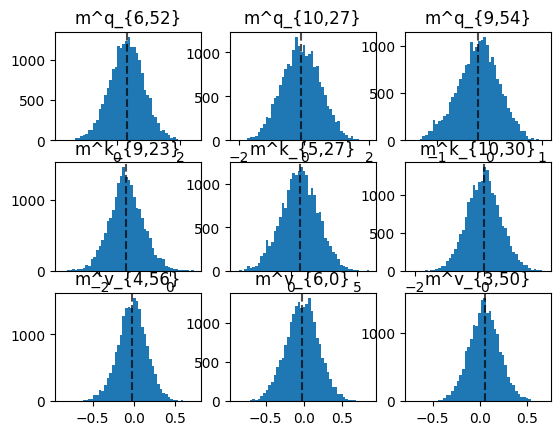

In [34]:
# Select context:
temperature = 3
explore_model(start, temperature, top_k)

### Short sentence 2 (from the Neuroscience article in Wikipedia)

In [35]:
start = "\nNeuroscience is the scientific study of the nervous system (the brain, spinal cord, and peripheral nervous system), its functions, and its disorders. It is a multidisciplinary science that combines"
top_k = 20000

T = 0.8

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(5) tensor(54)
Unique 874
tensor(3) tensor(47)
Uniq

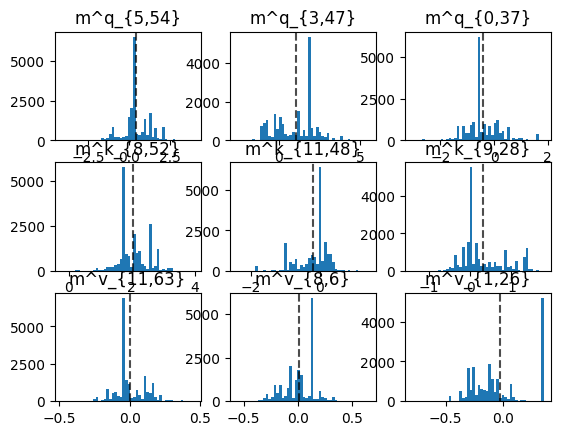

In [36]:
temperature = 0.8
explore_model(start, temperature, top_k)

T = 1

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(5) tensor(53)
Unique 1883
tensor(10) tensor(24)
Un

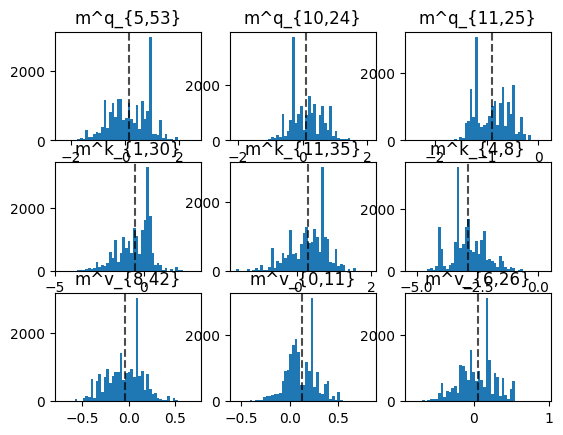

In [37]:
temperature = 1
explore_model(start, temperature, top_k)

T = 3

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(11) tensor(33)
Unique 10256
tensor(5) tensor(47)
U

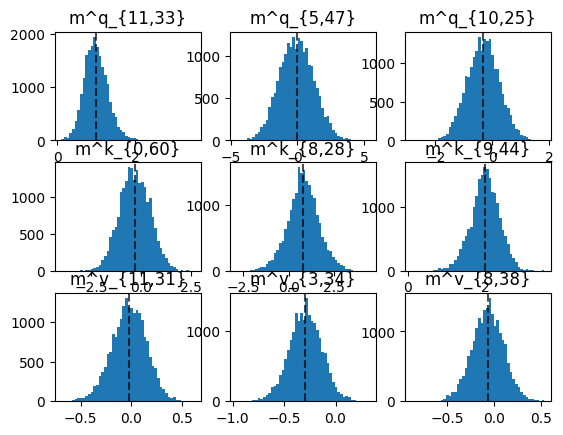

In [38]:
temperature = 3
explore_model(start, temperature, top_k)

### Short sentence 2 (cropped before)

In [39]:
start = "\nNeuroscience is the scientific study of the nervous system"
top_k = 20000

T = 0.8

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(9) tensor(22)
Unique 110
tensor(8) tensor(11)
Uniq

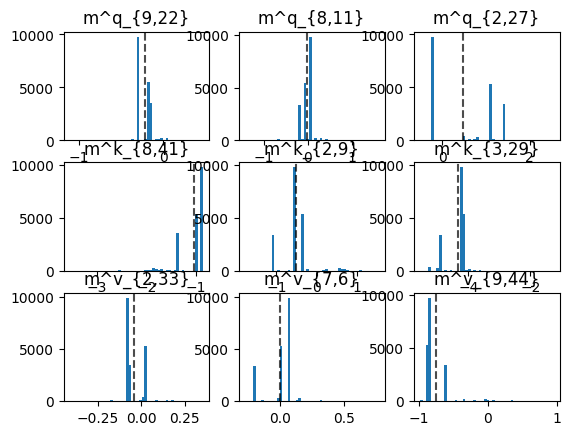

In [40]:
temperature = 0.8
explore_model(start, temperature, top_k)

T = 1

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(2) tensor(42)
Unique 384
tensor(9) tensor(10)
Uniq

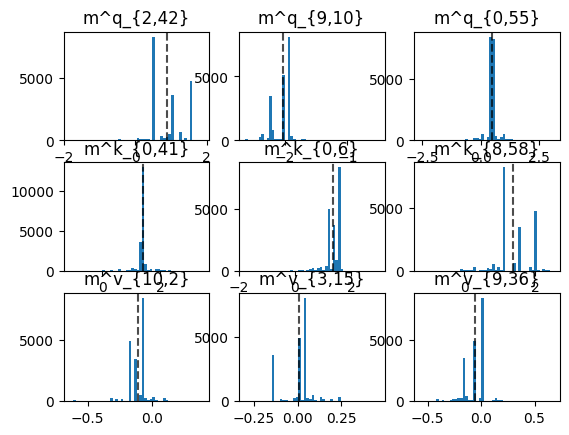

In [41]:
temperature = 1
explore_model(start, temperature, top_k)

T = 3

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(9) tensor(19)
Unique 10367
tensor(11) tensor(24)
U

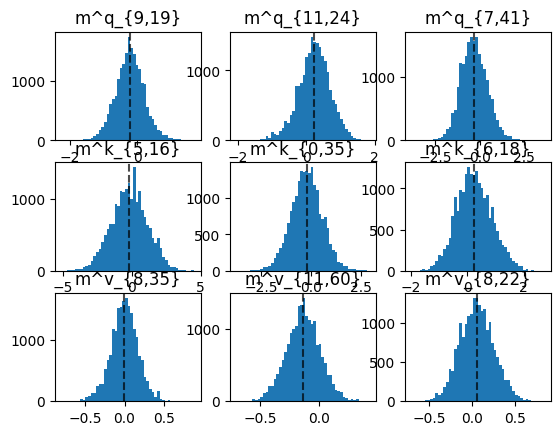

In [42]:
temperature = 3
explore_model(start, temperature, top_k)

### Long sample (sampled from GPT2)

In [43]:
start = "FILE:text_sample/sample_long_gpt2_2.txt"
top_k = 20000

T = 0.8

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(9) tensor(19)
Unique 931
tensor(7) tensor(16)
Uniq

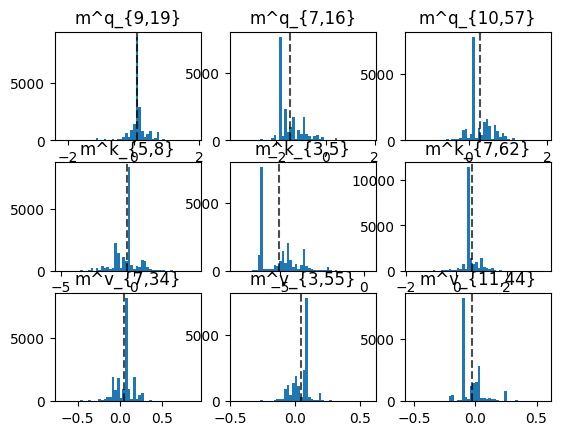

In [44]:
temperature = 0.8
explore_model(start, temperature, top_k)

T = 1

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(6) tensor(48)
Unique 2425
tensor(2) tensor(49)
Uni

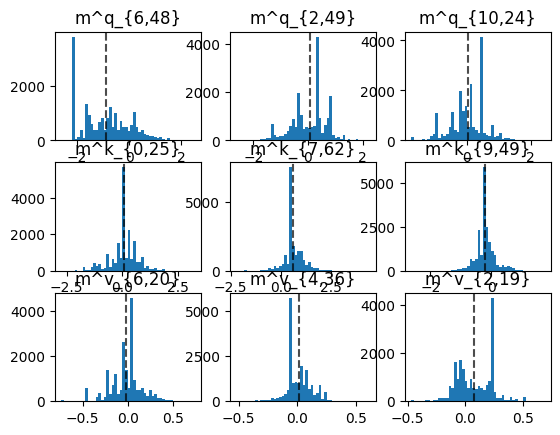

In [45]:
temperature = 1
explore_model(start, temperature, top_k)

T = 3

Computing sample  0
Computing sample  500
Computing sample  1000
Computing sample  1500
Computing sample  2000
Computing sample  2500
Computing sample  3000
Computing sample  3500
Computing sample  4000
Computing sample  4500
Computing sample  5000
Computing sample  5500
Computing sample  6000
Computing sample  6500
Computing sample  7000
Computing sample  7500
Computing sample  8000
Computing sample  8500
Computing sample  9000
Computing sample  9500
Computing sample  10000
Computing sample  10500
Computing sample  11000
Computing sample  11500
Computing sample  12000
Computing sample  12500
Computing sample  13000
Computing sample  13500
Computing sample  14000
Computing sample  14500
Computing sample  15000
Computing sample  15500
Computing sample  16000
Computing sample  16500
Computing sample  17000
Computing sample  17500
Computing sample  18000
Computing sample  18500
Computing sample  19000
Computing sample  19500
Plot q
tensor(8) tensor(53)
Unique 11131
tensor(4) tensor(60)
Un

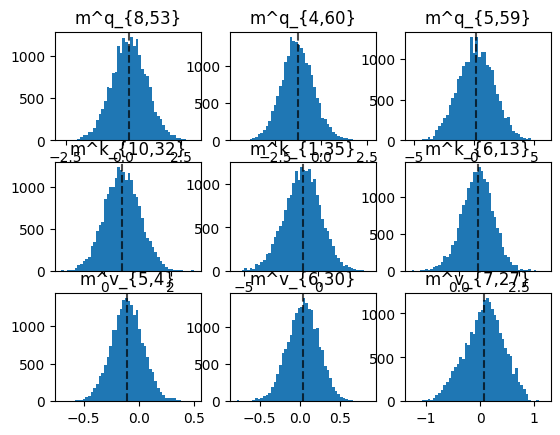

In [46]:
temperature = 3
explore_model(start, temperature, top_k)

### Other tests:

In [ ]:
# Select context:
start = "\n" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
# start = "\nMy lord, cheerfully made" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
# start = "\nWARWICK:\nWhat, wilt thou, wilt thou not, for thy head?\nQUEEN MARGARET:\nHow now, madam?"
# start = "FILE:text_sample/sample_long.txt"
# start = "FILE:text_sample/sample_long_gpt2_2.txt"
start = "\nThe Lion King was conceived during conversations among various Disney executives, to whom several writers submitted early treatments. Original director George Scribner had envisioned"
# start = "\nNeuroscience is the scientific study of the nervous system (the brain, spinal cord, and peripheral nervous system), its functions, and its disorders. It is a multidisciplinary science that combines"

temperature = 0.8
top_k = 10000

explore_model(start, temperature, top_k)